In [32]:
import seaborn as sns
import json
from matplotlib import pyplot
import numpy as np
import matplotlib.pyplot as plt

In [33]:
def extend(lst, desired_length, fill_value=None):
    return lst + [fill_value] * (desired_length - len(lst))

In [41]:
# Angle between two vectors in degrees.
def vang(a, b): 
    return np.arccos(a.dot(b)) / np.pi * 180

# Vector from two angles
def vec(x):
    return np.array([np.cos(x[0]) * np.sin(x[1]), np.sin(x[0]) * np.sin(x[1]), np.cos(x[1])])

# convert in-game angles to radian coordiantes
def gamea(a, b):
    return [b / 180 * np.pi, (90 - a) / 180 * np.pi]

# pixels distance between two vectors (a,b) and (c,d) defined by in-game angles.
def points(a, b, c, d):
    # 3/4 seems to be a change in game engine?
    return vang(vec(gamea(a, b)), vec(gamea(c, d))) / 0.022

def vector_length(x, y):
    return np.sqrt(x * x + y * y)

def diff(a, b):
#     return sum([abs(x[0] - x[1]) for x in zip(a, b)])
#     return pow(sum(d), 0.5)
    d = [pow(x[0] - x[1], 2) for x in zip(a, b)]
    return sum([max(x - 3, 0) for x in d])

def dist_score(x):
    return np.exp(-0.0004 * np.power(x, 2))

def rc_score(r1, r2):
    return 100 * np.mean([dist_score(vector_length(r1['x'][i] - r2['x'][i], r1['y'][i] - r2['y'][i])) for i in range(len(r1['x']))])

def median_delta_recoil(rc):
    mx = [0]
    my = [0]
    x = 0
    y = 0
    n = len(rc[0]['x'])
    for i in range(1, n):
        dx = []
        dy = []
        for r in rc:
            dx.append(r['x'][i] - r['x'][i-1])
            dy.append(r['y'][i] - r['y'][i-1])
        x += np.median(dx)
        y += np.median(dy)
        mx.append(np.round(x, 1))
        my.append(np.round(y, 1))
    return mx, my

def mean_recoil(rc):
    mx = [0]
    my = [0]
    x = 0
    y = 0
    n = len(rc[0]['x'])
    for i in range(1, n):
        dx = []
        dy = []
        for r in rc:
            dx.append(r['x'][i])
            dy.append(r['y'][i])
        x = np.mean(dx)
        y = np.mean(dy)
        mx.append(np.round(x, 1))
        my.append(np.round(y, 1))
    return mx, my

In [35]:
def rpm(name):
  with open('../client/specs.json') as f:
    specs = json.load(f)
  for x in specs:
    if x['name'] == name:
      return x['rpm']
  return 1

In [36]:
np.round(points(9.83, 38.68, 1.56, 40.33), 2)

np.float64(383.23)

In [37]:
def to_game_distances(r):
  [ia, ib] = r['anchor_indexes']
  xa, ya = r['x'][ia], r['y'][ia]
  xb, yb = r['x'][ib], r['y'][ib]
  dg = r['anchor_in_game_distance']
  d = vector_length(xb - xa, yb - ya)
  r['x'] = [x * dg / d for x in r['x']]
  r['y'] = [y * dg / d for y in r['y']]
  return r

def get_recoils(w):
  with open('../client/raw_recoils.json') as f:
    raw = json.load(f)
  return [to_game_distances(x) for x in raw if x['weapon'] == w]

# recoils 3
"x": [0, -14.1, -18.1, -42.7, -63.0, -65.7, -63.4, -50.8, -28.5, -20.4, -13.6, -11.8, -23.8, -46.9, -68.1, -89.5, -93.5, -101.7, -123.0, -144.7, -155.5, -160.2, -155.2, -140.0, -122.7, -107.5, -92.4, -77.9, -75.1],
"y": [0, -47.8, -68.0, -101.6, -122.5, -150.6, -178.3, -185.3, -175.5, -171.0, -182.2, -202.1, -208.4, -226.3, -226.5, -227.6, -244.7, -266.2, -280.0, -294.9, -296.7, -303.4, -317.9, -323.3, -333.1, -337.0, -341.3, -338.5, -355.9],
"time_points": [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800],
29 29 29 29


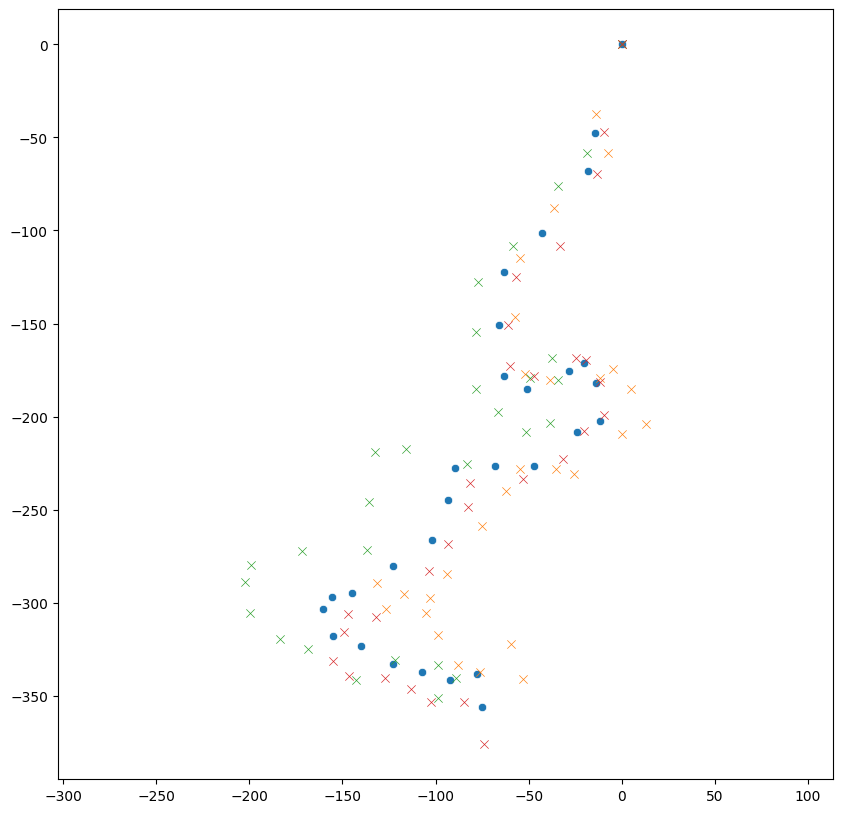

In [38]:
w = 'flatline'
rc = get_recoils(w)
print('# recoils', len(rc))

_, ax = plt.subplots(figsize=(10,10))
plt.axis('equal')

n = len(rc[0]['x'])
wrpm = rpm(w)

x, y = mean_recoil(rc)
sns.scatterplot(ax=ax, x=x, y=y)

for r in rc:
    sns.scatterplot(ax=ax, x=r['x'], y=r['y'], marker='x')

t = [int(i * 60.0 * 1000 / wrpm) for i in range(n)]

s = json.dumps({
    'x': x,
    'y': y,
    'time_points': t,
    })
print(s.replace('], ','],\n')[1:-1] + ',')
print(n, len(x), len(y), len(t))

In [40]:
if len(rc) > 2:
  for i in range(len(rc)):
    sub = rc[:i] + rc[i+1:]
    tx, ty = mean_recoil(sub)
    print('w/o', i, ':', np.mean([rc_score(r, {'x': tx, 'y': ty}) for r in sub]))
else:
  print('not enough patterns')
# tx, ty = mean_delta_recoil(rc)
# print('mean_delta_recoil', np.mean([rc_score(r, {'x': tx, 'y': ty}) for r in rc]))
# tx, ty = median_delta_recoil(rc)
# print('median_delta_recoil', np.mean([rc_score(r, {'x': tx, 'y': ty}) for r in rc]))
# tx, ty = mean_delta2_recoil(rc)
# print('mean_delta2_recoil', np.mean([rc_score(r, {'x': tx, 'y': ty}) for r in rc]))

w/o 0 : 87.62275139073951
w/o 1 : 93.9111500657836
w/o 2 : 76.98190892898589


0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73
0.73


(0.9214023304810413,
 False,
 [72.85203629223777,
  73.21199802178187,
  81.10565278963901,
  74.22552930314487,
  76.2513810902986,
  76.59673800615211,
  57.80636425730111,
  91.09864059973573,
  80.59281128324261,
  74.19502837889051],
 'err',
 [23591839.190000035,
  22586885.669999987,
  22485575.289999966,
  22012471.13999998,
  21863496.440000013,
  21574435.630000014,
  21852257.95000001,
  21737575.609999992,
  21635302.220000003])

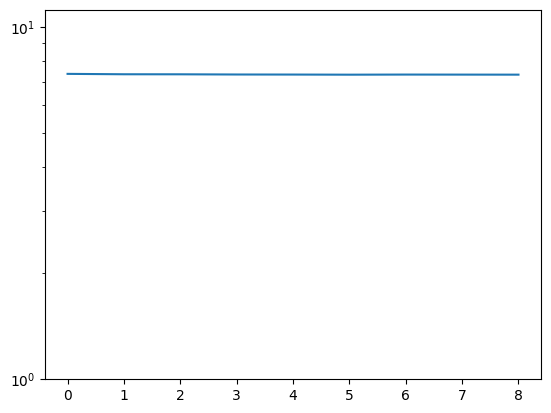

In [90]:
k = len(rc) - 1
err = [0] * k
# maxerr = [0] * len(rc)
# minerr = [100000000] * len(rc)
tx, ty = mean_abs_recoil(rc)
for i in range(200):
    t = np.random.permutation(rc)
    for j in range(k):
        x, y = mean_recoil(t[:j+1])
        d = diff(x, tx) + diff(y, ty)
        err[j] += d
        # minerr[j] = min(minerr[j], d)
        # maxerr[j] = max(maxerr[j], d)

bd = 0
bi = 0
for i, r in enumerate(rc):
    print(i, r['comment'], rc_score(r, {'x': tx, 'y': ty}))
    d = diff(r['x'][:n], tx) + diff(r['y'][:n], ty)
    if d > bd:
        bd = d
        bi = i
print('bad', bi, rc[bi]['comment'])
plt.yscale('log')
plt.ylim(1, None)
sns.lineplot(x=range(k), y=err)
d = err[-2] / err[0]
d, d < 0.01, [rc_score(r, {'x': tx, 'y': ty}) for r in rc], 'err', err